# Run hacked AlphaFold2 on the designed paired state Y's

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /global/cfs/cdirs/m4129/projects/crispy_shifty/projects/crispy_shifties
running on node: nid002360


### Set working directory to the root of the crispy_shifty repo
Note: We want to use perlmutter

In [2]:
os.chdir("/global/cfs/cdirs/m4129/projects/crispy_shifty")

### Fix the paths
Necessary because we are on perlmutter

In [3]:
from crispy_shifty.utils.io import fix_path_prefixes

pairs = os.path.join(
    os.getcwd(),
    "projects/crispy_shifties/06_mpnn_paired_states/mpnn_paired_states.pair",
)
new_pairs = fix_path_prefixes(
    find="/mnt",
    replace="/global/cfs/cdirs/m4129",
    file=pairs,
    overwrite=True,
)

/global/cfs/cdirs/m4129/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Run AF2 on the designed paired states Y's

In [4]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "07_fold_paired_states_Y"
design_list_file = os.path.join(
    os.getcwd(),
    "projects/crispy_shifties/06_mpnn_paired_states/mpnn_paired_states.pair",
)
output_path = os.path.join(f"/pscratch/sd/p/pleung/{simulation_name}")

options = " ".join(
    [
        "out:level 200",
    ]
)
extra_kwargs = {"models": "1"}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.folding.fold_paired_state_Y",
    design_list_file=design_list_file,
    output_path=output_path,
    perlmutter_mode=True,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    time="29:30",
)

Run the following command with your desired environment active:
sbatch -a 1-250 /pscratch/sd/p/pleung/07_fold_paired_states_Y/run.sh


### Set working directory to the root of the crispy_shifty repo
Note: We rsync the perlmutter results, now back on the digs

In [2]:
os.chdir("/projects/crispy_shifty")

### Collect scorefiles of the folded paired state Ys and concatenate

In [3]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "07_fold_paired_states_Y"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile
TODO might have to switch to a dask accelerated approach for production

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

  0%|          | 0/97000 [00:00<?, ?it/s]

### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [6]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [7]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"]
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(1000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

### Remove score terms we don't care about

In [8]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

2000
['Y_mean_pae', 'Y_mean_pae_interaction', 'Y_mean_pae_interaction_AB', 'Y_mean_pae_interaction_BA', 'Y_mean_pae_intra_chain', 'Y_mean_pae_intra_chain_A', 'Y_mean_pae_intra_chain_B', 'Y_mean_plddt', 'Y_model', 'Y_pTMscore', 'Y_recycles', 'Y_rmsd_to_reference', 'Y_seed', 'Y_tol', 'Y_type', 'bb_clash', 'bb_clash_delta', 'bb_clash_delta_x', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'interface', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_msd_design_area', 'mpnn_msd_temperature', 'mpnn_tem

In [9]:
from crispy_shifty.plotting.utils import histplot_df, pairplot_df

to_plot = [
    "best_average_plddts",
    "best_model",
    "best_ptm",
    "best_rmsd_to_input",
    "cms_AcB",
    "cms_AnAc",
    "cms_AnAcB",
    "cms_AnB",
    "designed_by",
    "interface",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_interaction_AB",
    "mean_pae_interaction_BA",
    "mean_pae_intra_chain",
    "mean_pae_intra_chain_A",
    "mean_pae_intra_chain_B",
    "mean_plddt",
    "mismatch_probability_parent",
    "pTMscore",
    "packstat_parent",
    "pdb",
    "recycles",
    "rmsd_to_reference",
    "sap_parent",
    "sc_AcB",
    "sc_AnAc",
    "sc_AnAcB",
    "sc_AnB",
    "sc_all_parent",
    "score_per_res",
    "score_per_res_parent",
    "ss_sc",
    "state",
    "topo",
]
print(to_plot)

['best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'interface', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'pTMscore', 'packstat_parent', 'pdb', 'recycles', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'score_per_res', 'score_per_res_parent', 'ss_sc', 'state', 'topo']


### Plot before and after multistate design AF2 metrics

6it [00:00, 16.48it/s]


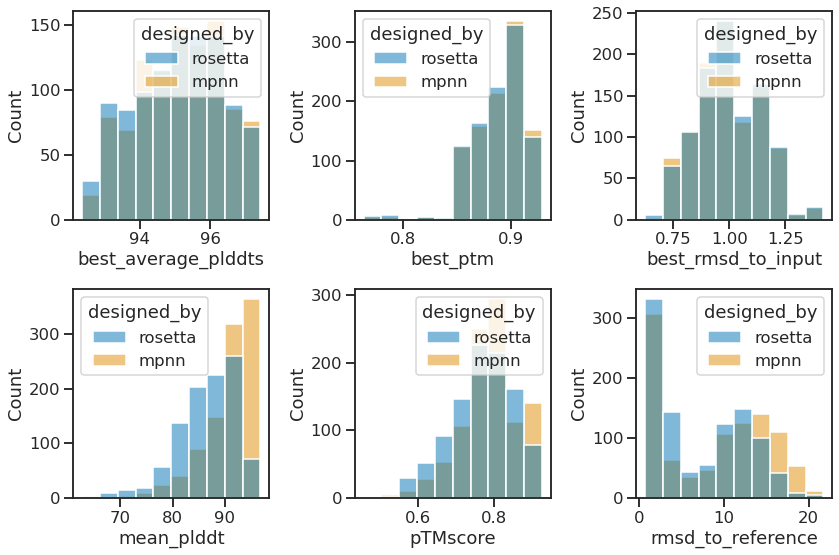

In [10]:
cols = [
    "best_average_plddts",
    "best_ptm",
    "best_rmsd_to_input",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores.png"))

<Figure size 1728x1728 with 0 Axes>

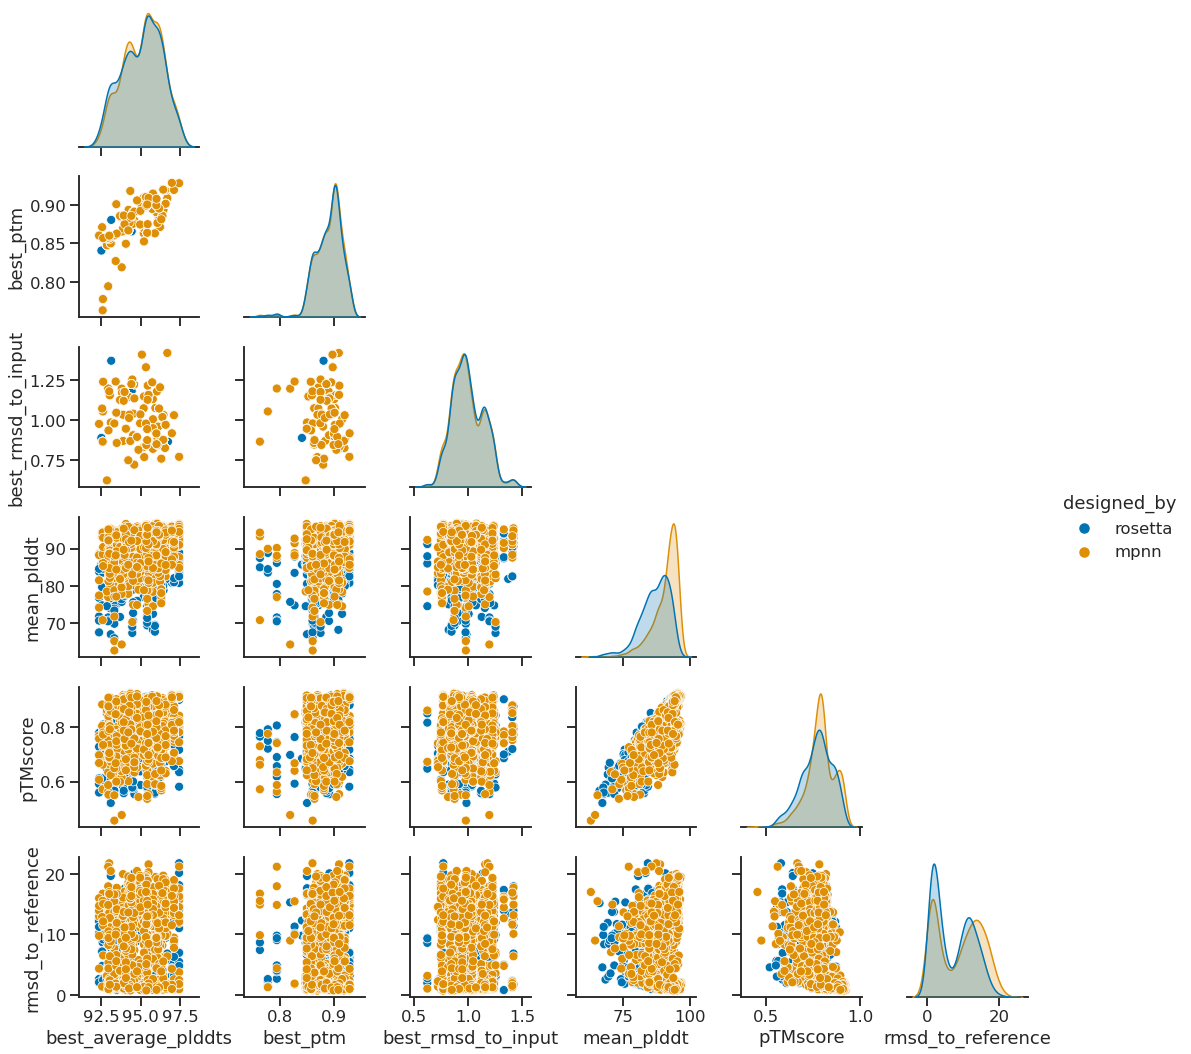

In [11]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_paired.png"))

In [12]:
# the_fig = histplot_df(
#     df=sample_df,
#     cols=cols,
#     bins=10,
#     hue="interface",
# )

In [13]:
# the_fig = pairplot_df(
#     df=sample_df,
#     cols=cols,
#     hue="interface",
# )

### Plot effects of MPNN temperature and selector areas on AF2 metrics

In [14]:
# mpnn["mpnn_temperature"] = mpnn["mpnn_temperature"].astype(str)

# cols = [
#     "best_average_plddts",
#     "best_ptm",
#     "best_rmsd_to_input",
#     "mean_plddt",
#     "pTMscore",
#     "rmsd_to_reference",
# ]
# the_fig = histplot_df(
#     df=mpnn,
#     cols=cols,
#     bins=10,
#     hue="mpnn_temperature",
# )

In [15]:
# the_fig = pairplot_df(
#     df=mpnn,
#     cols=cols,
#     hue="mpnn_temperature",
# )

6it [00:00, 13.85it/s]


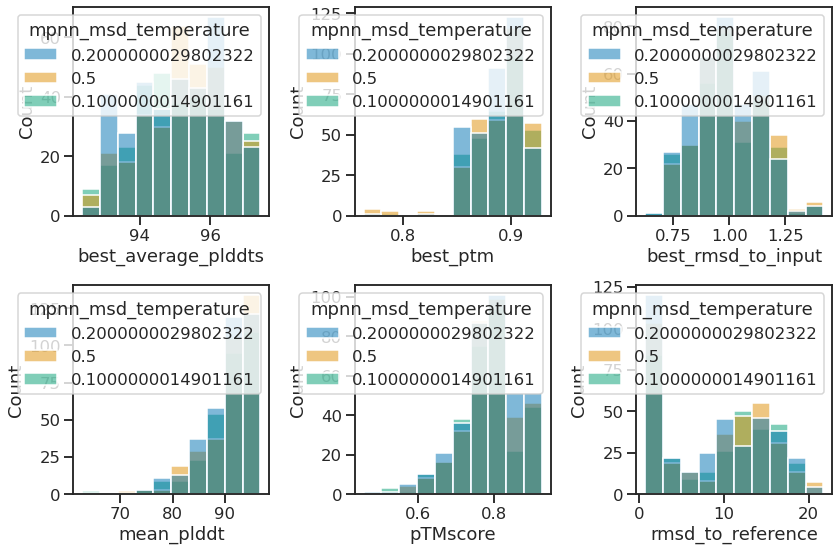

In [16]:
mpnn["mpnn_msd_temperature"] = mpnn["mpnn_msd_temperature"].astype(str)

cols = [
    "best_average_plddts",
    "best_ptm",
    "best_rmsd_to_input",
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_msd_temperature",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_temp.png"))

<Figure size 1728x1728 with 0 Axes>

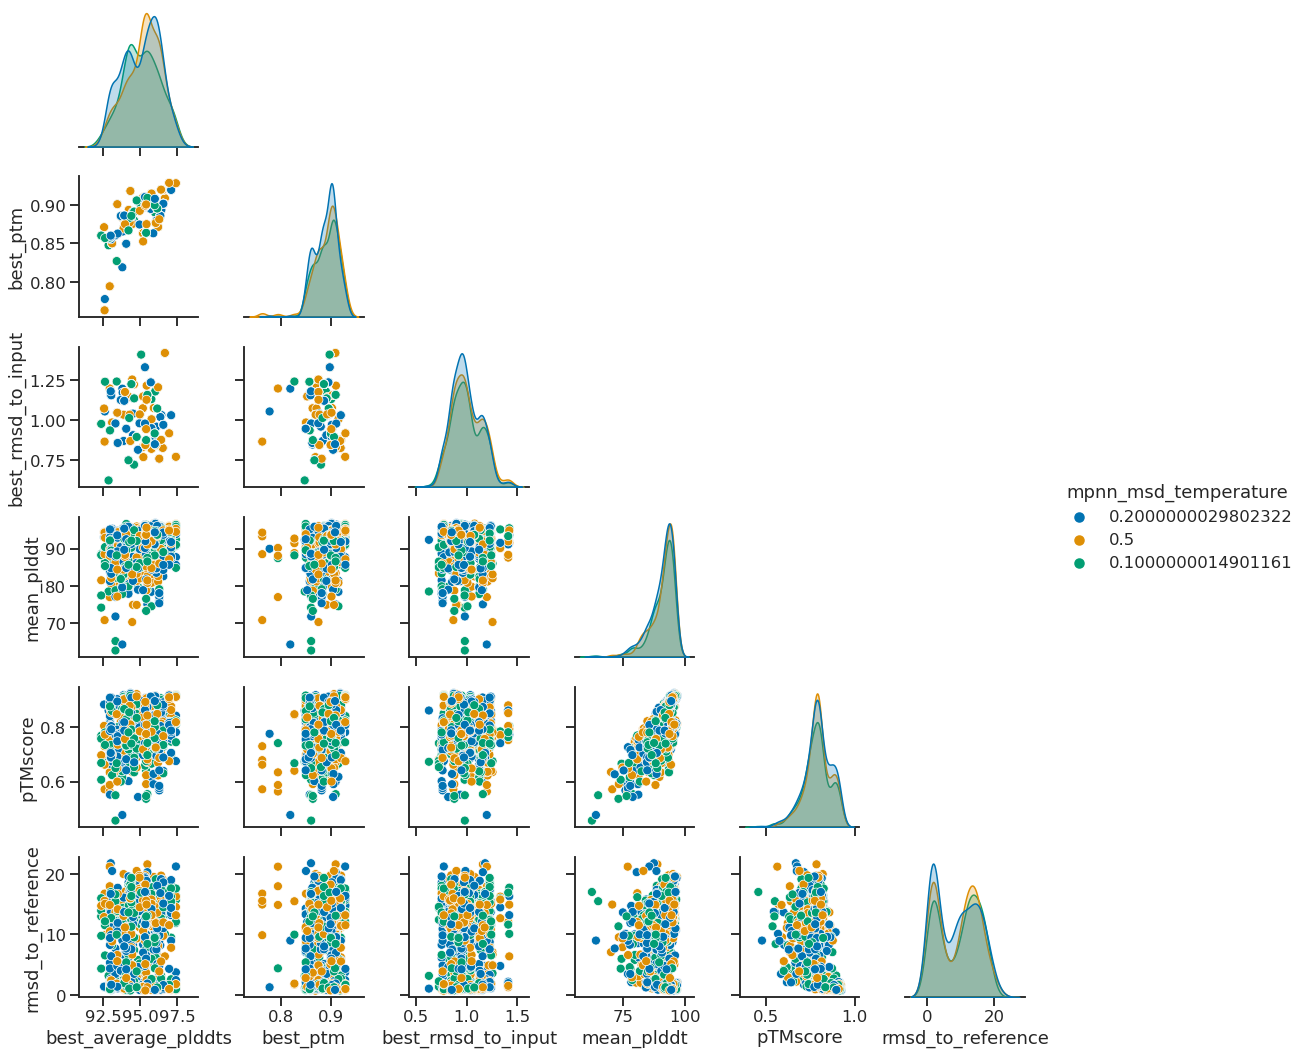

In [17]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_msd_temperature",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_temp_paired.png"))

6it [00:00, 13.19it/s]


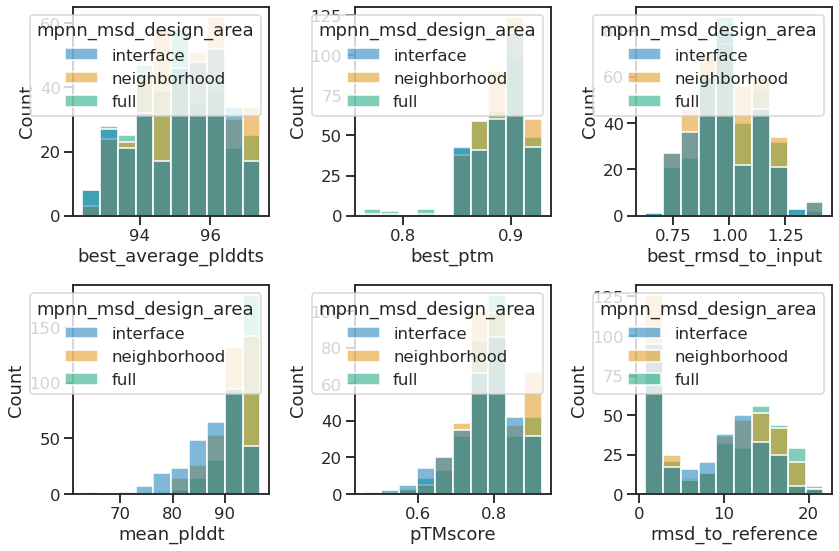

In [18]:
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_msd_design_area",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area.png"))

<Figure size 1728x1728 with 0 Axes>

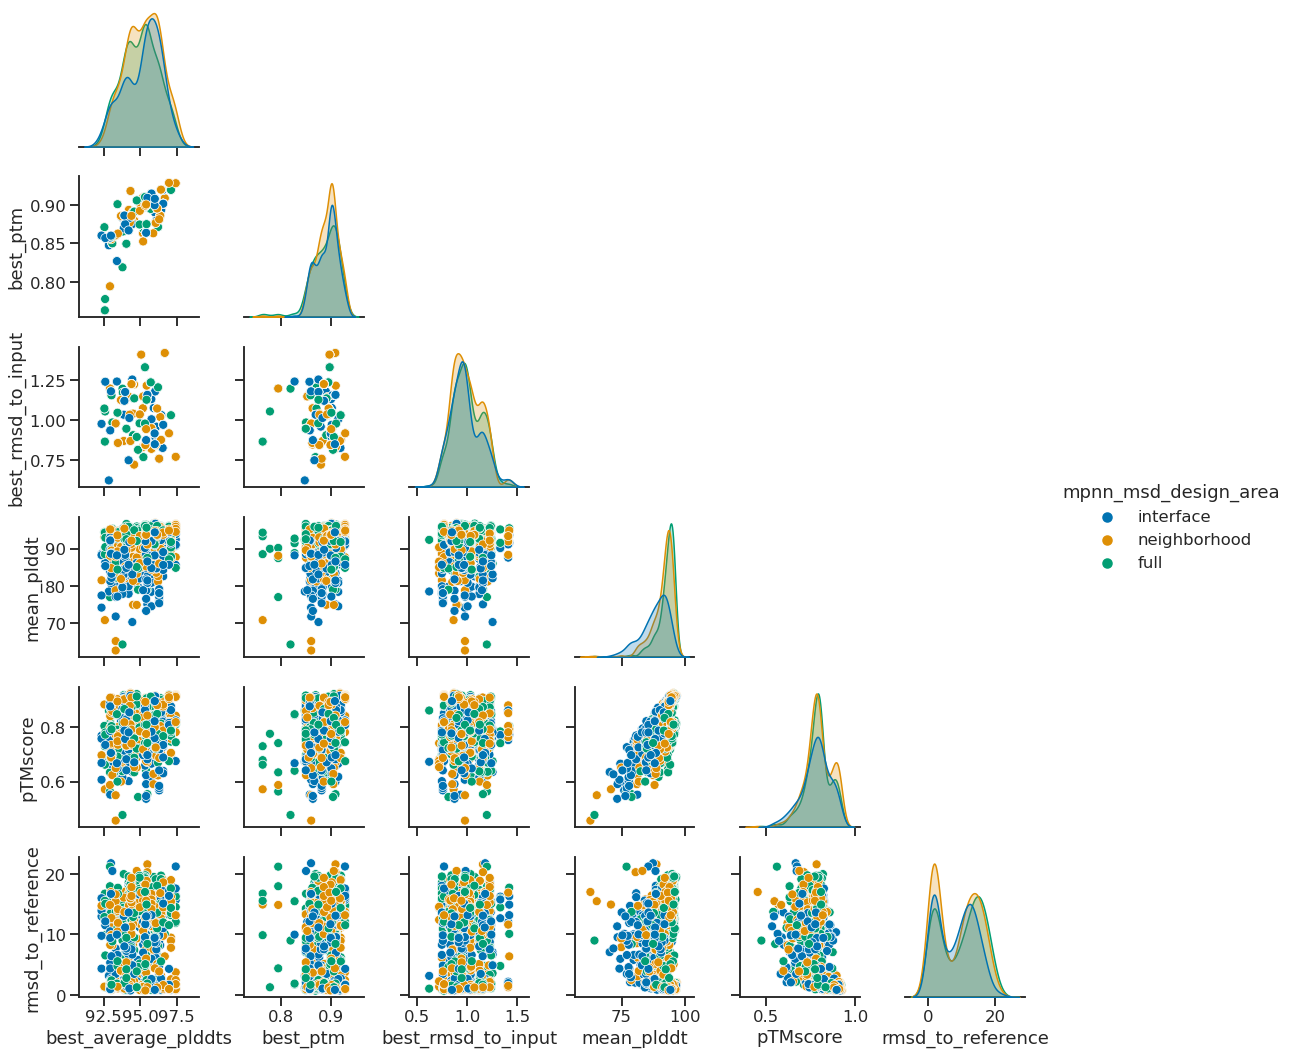

In [19]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_msd_design_area",
)
plt.savefig(os.path.join(output_path, "old_vs_new_af2_scores_area_paired.png"))

In [20]:
# sample_df["best_model"] = sample_df["best_model"].astype(str)
# the_fig = histplot_df(
#     df=sample_df,
#     cols=cols,
#     bins=10,
#     hue="best_model",
# )

In [21]:
# sample_df["best_model"] = sample_df["best_model"].astype(str)
# the_fig = histplot_df(
#     df=sample_df,
#     cols=cols,
#     bins=10,
#     hue="topo",
# )

### Plot interface metrics

6it [00:00, 15.57it/s]


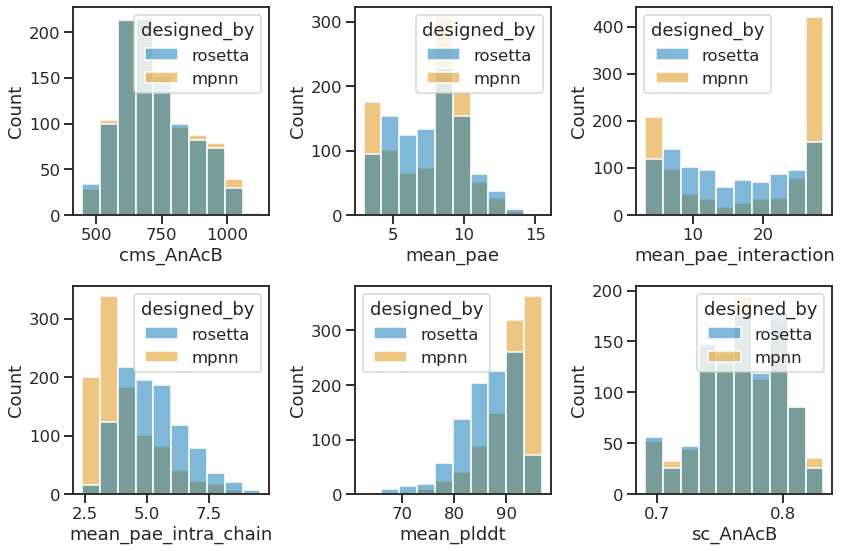

In [22]:
cols = [
    "cms_AnAcB",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
    "mean_plddt",
    "sc_AnAcB",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "interface_scores.png"))

<Figure size 1728x1728 with 0 Axes>

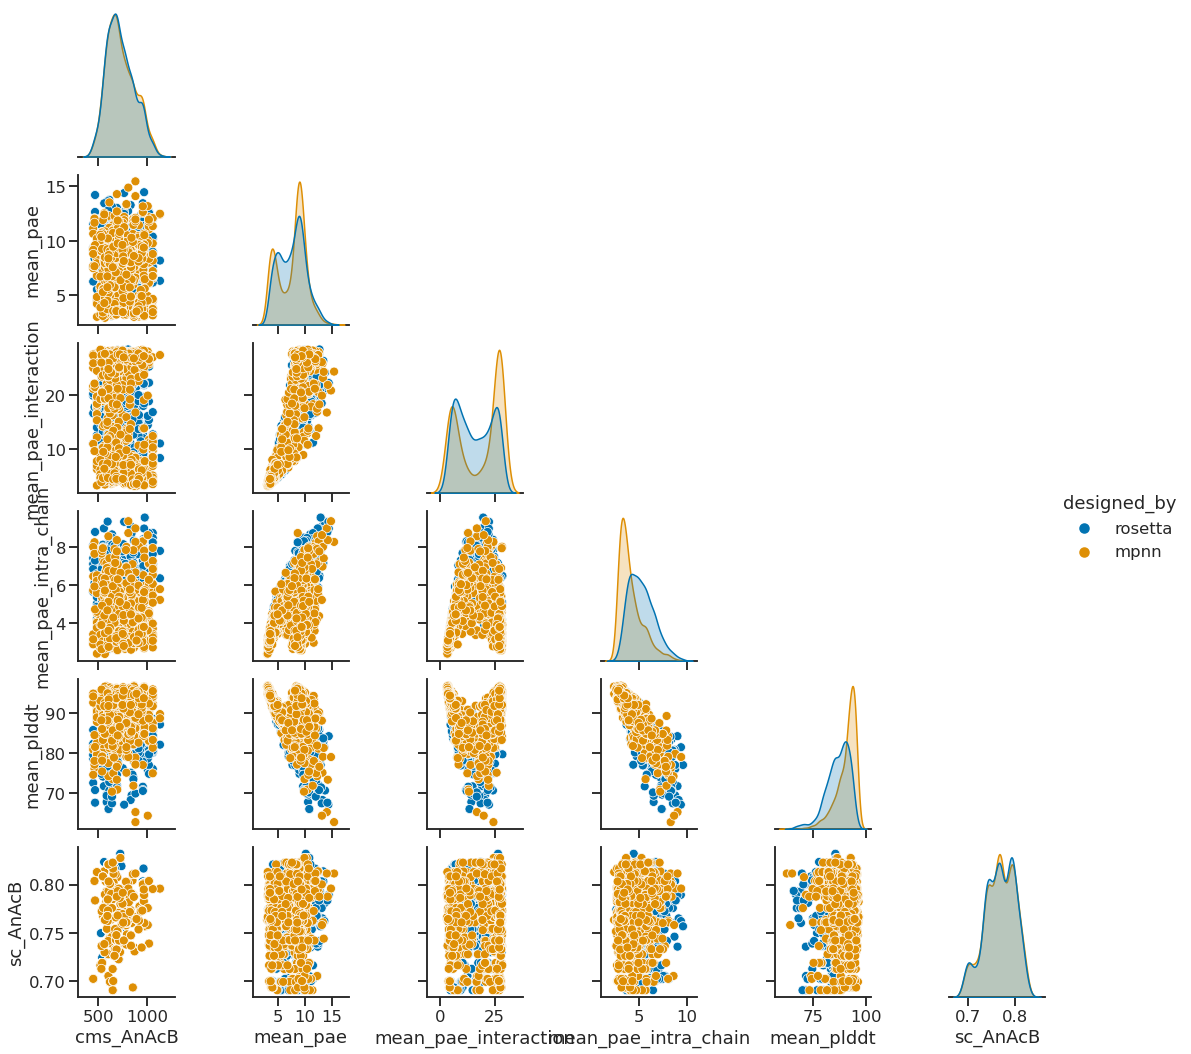

In [23]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "interface_scores_paired.png"))

In [24]:
# the_fig = histplot_df(
#     df=sample_df,
#     cols=cols,
#     bins=10,
#     hue="interface",
# )

In [25]:
# the_fig = pairplot_df(
#     df=sample_df,
#     cols=cols,
#     hue="interface",
# )

### Plot effects of MPNN temperature and selector areas on interface metrics

6it [00:00,  7.09it/s]


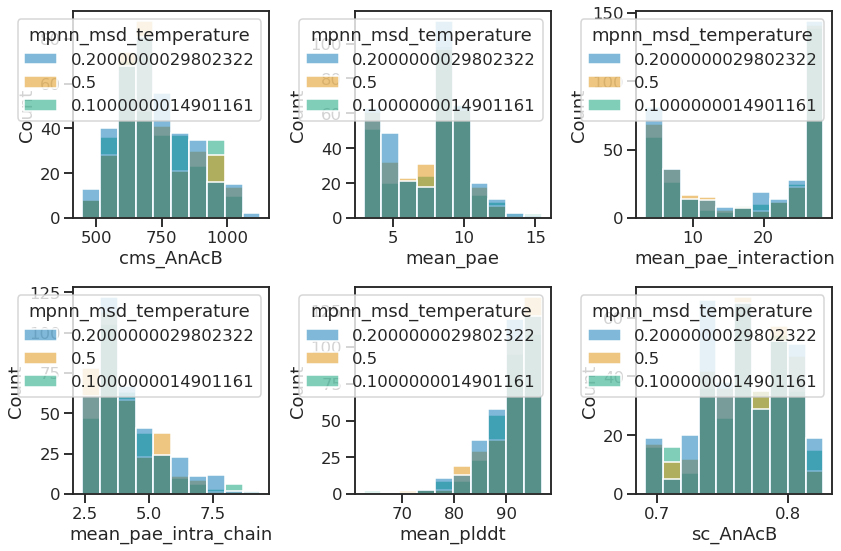

In [26]:
cols = [
    "cms_AnAcB",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
    "mean_plddt",
    "sc_AnAcB",
]
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_msd_temperature",
)
plt.savefig(os.path.join(output_path, "interface_scores_temp.png"))

<Figure size 1728x1728 with 0 Axes>

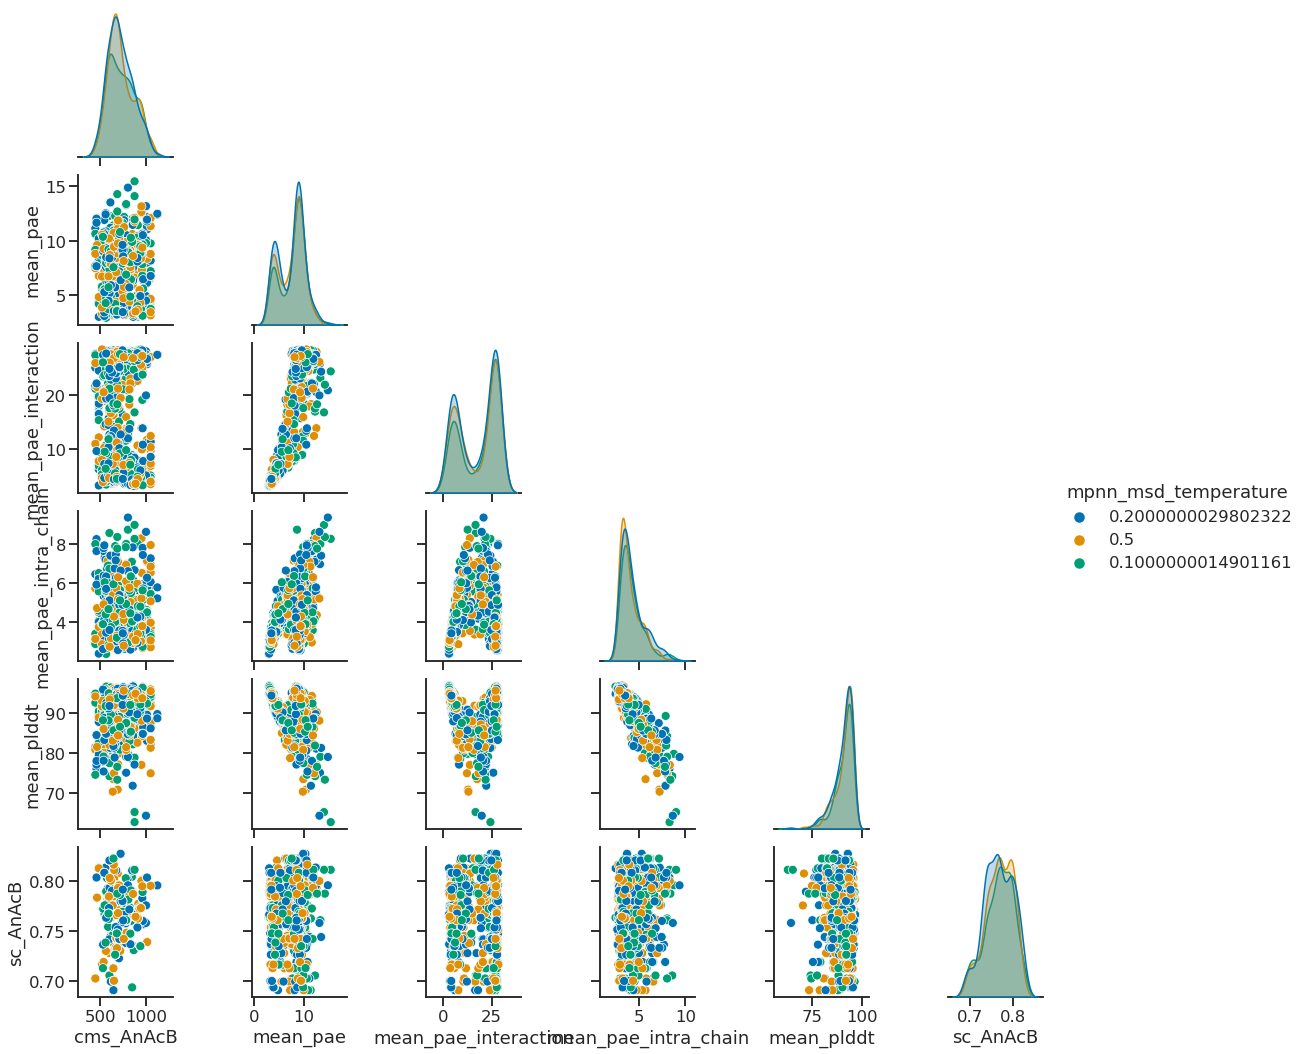

In [27]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_msd_temperature",
)
plt.savefig(os.path.join(output_path, "interface_scores_temp_paired.png"))

6it [00:00,  7.41it/s]


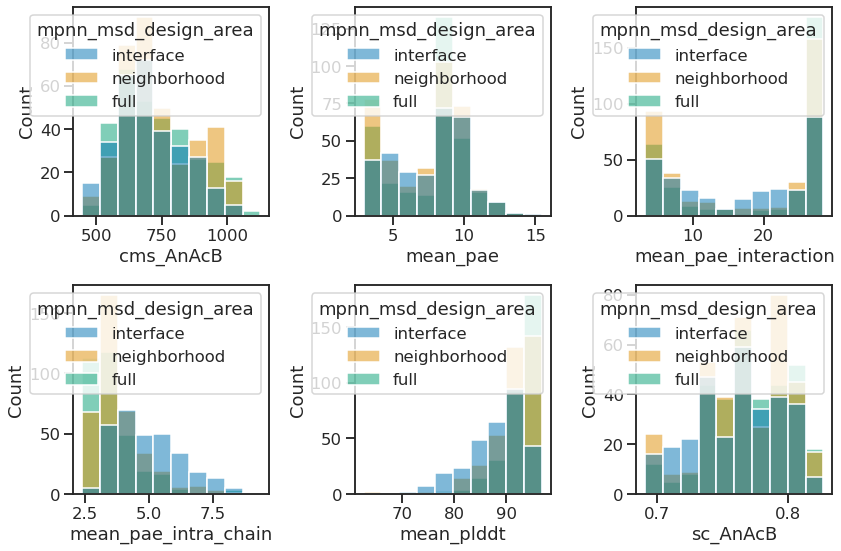

In [28]:
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_msd_design_area",
)
plt.savefig(os.path.join(output_path, "interface_scores_area.png"))

<Figure size 1728x1728 with 0 Axes>

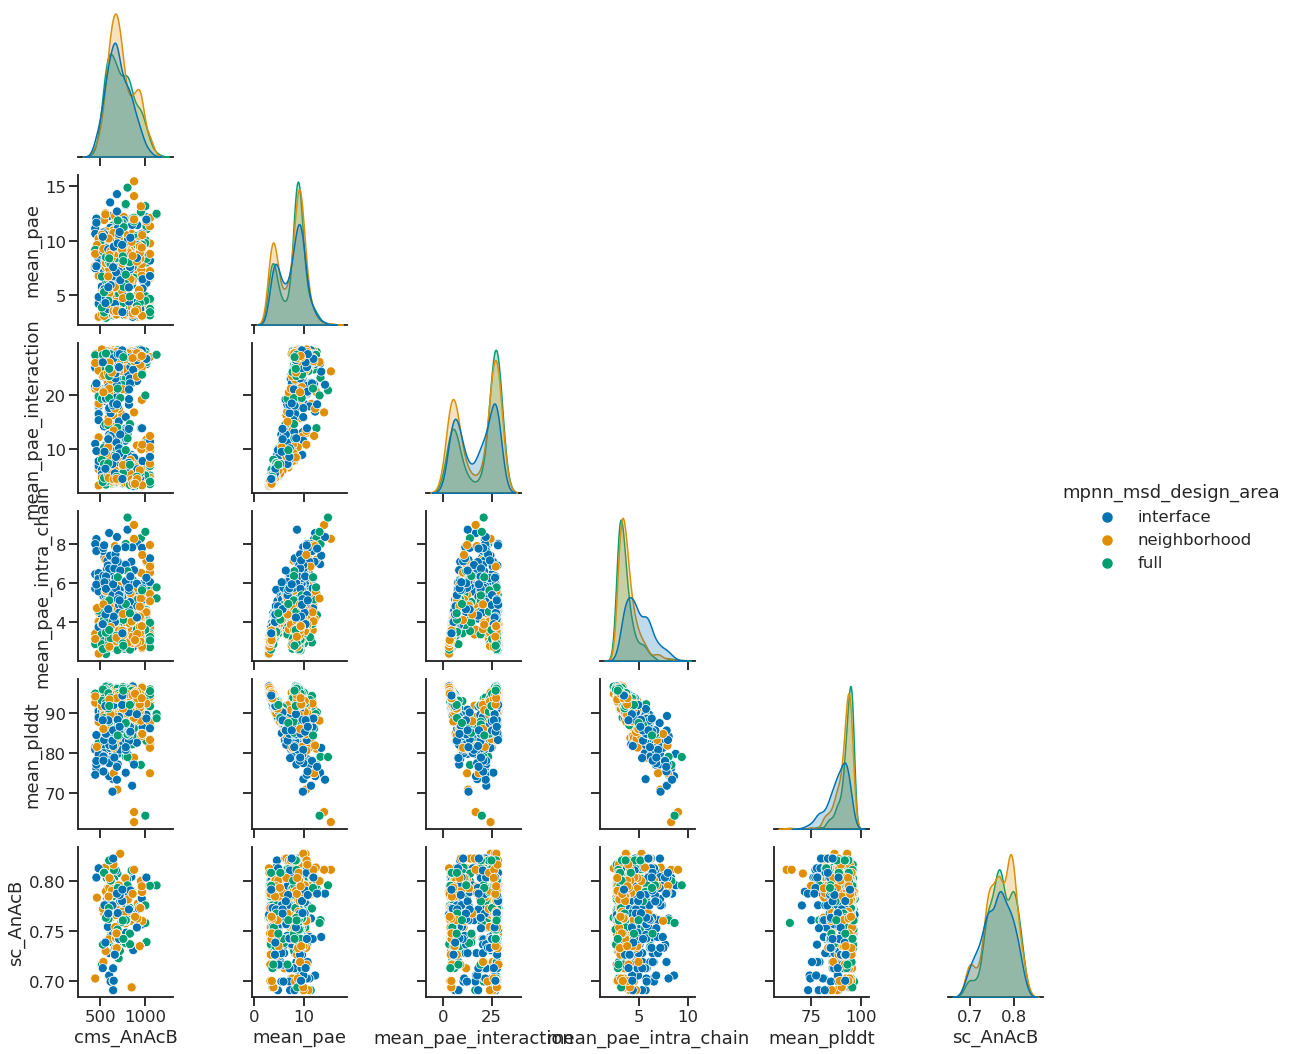

In [29]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_msd_design_area",
)
plt.savefig(os.path.join(output_path, "interface_scores_area_paired.png"))

### Filter the whole df

In [38]:
query = "mean_plddt > 90 and mean_pae_interaction < 5 and rmsd_to_reference < 1.5"

filtered = scores_df.query(query)
len(filtered)

10364

In [40]:
print(list(sorted(set([v for v in filtered.parent.values if len(v) == 5]))))
print(len([v for v in filtered.designed_by.values if v == "rosetta"]))

['DHR20', 'DHR21', 'DHR24', 'DHR26', 'DHR27', 'DHR49', 'DHR52', 'DHR54', 'DHR59', 'DHR70', 'DHR80', 'DHR81', 'DHR82']
59


### Plot topo and scaffold_type fraction before and after

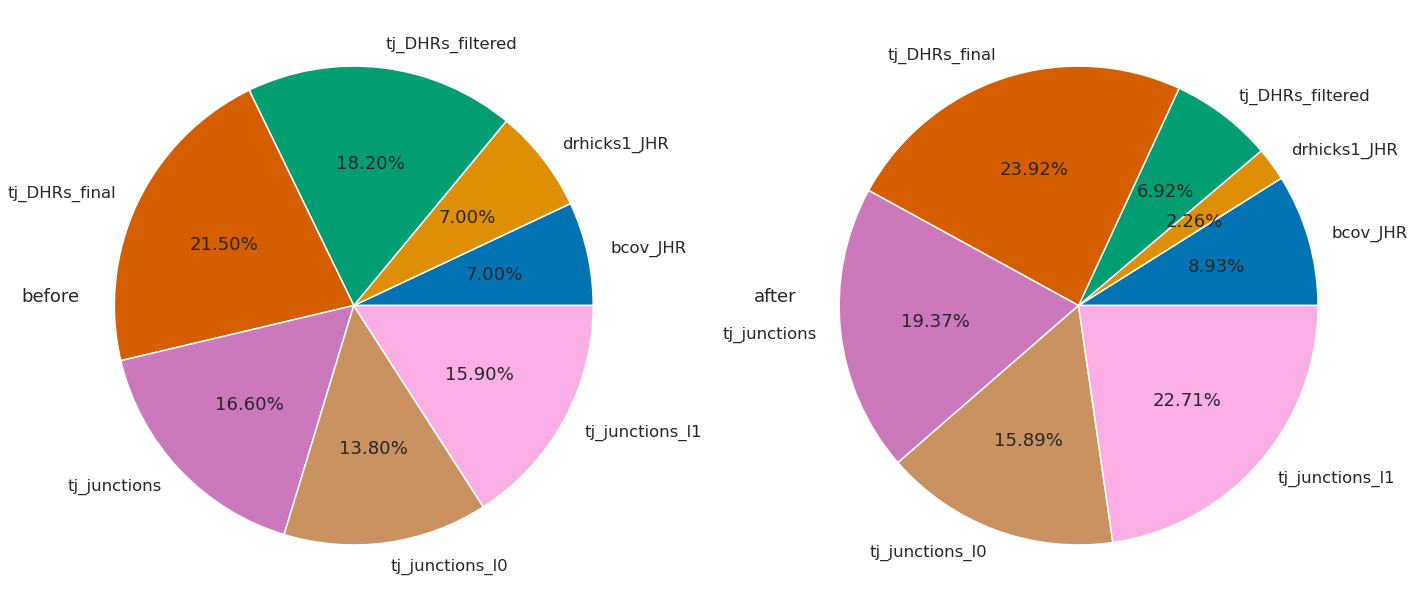

In [41]:
(
    fig,
    (ax1, ax2),
) = plt.subplots(ncols=2, figsize=(20, 10), tight_layout=True)
scores_df.groupby("scaffold_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax1)
ax1.set_ylabel("before", rotation=0)
filtered.groupby("scaffold_type").size().plot(kind="pie", autopct="%1.2f%%", ax=ax2)
ax2.set_ylabel("after", rotation=0)

plt.savefig(os.path.join(output_path, "filtering_effect_scaffold_type.png"))

### Sort the filtered df by length

In [42]:
filtered = filtered.sort_values("looped_length")

### Save a list of outputs
Sort by length

In [43]:
simulation_name = "07_fold_paired_states_Y"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

with open(os.path.join(output_path, "folded_paired_states.list"), "w") as f:
    for path in tqdm(filtered.index):
        print(path, file=f)

  0%|          | 0/10364 [00:00<?, ?it/s]

### Save a list of chunked outputs
50 per chunk

In [44]:
from more_itertools import ichunked

with open(os.path.join(output_path, "folded_paired_states.pair"), "w") as f:
    for paths in ichunked(tqdm(filtered.index), 50):
        line = "____".join(paths)
        print(line, file=f)

  0%|          | 0/10364 [00:00<?, ?it/s]

### Prototyping blocks

test `fold_paired_state_Y`

In [ ]:
%%time 
from operator import gt, lt
import pyrosetta

filter_dict = {
    "mean_plddt": (gt, 85.0),
    "rmsd_to_reference": (lt, 2.2),
    "mean_pae_interaction": (lt, 10.0),
}

pyrosetta.init()


sys.path.insert(0, "~/projects/crispy_shifty/") # TODO projects
from crispy_shifty.protocols.folding import fold_paired_state_Y

t = fold_paired_state_Y(
        None,
        **{
#             'fasta_path': 'TODO',
            "filter_dict": filter_dict,
            "models": [1], # TODO
            'pdb_path': '/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/06_mpnn_paired_states/decoys/0000/06_mpnn_paired_states_e6c08d9247294efbb7f84c704711447b.pdb.bz2____/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/06_mpnn_paired_states/fastas/0000/06_mpnn_paired_states_e6c08d9247294efbb7f84c704711447b.fa',
#             'fasta_path': 'bar.fa',
#             "models": [1, 2], # TODO
#             'pdb_path': 'foo.pdb.bz2',
            
        }
)
for i, tppose in enumerate(t):
    tppose.pose.dump_pdb(f"{i}.pdb")

In [ ]:
tppose.pose.scores